# Test task Data Scientist
The task itself:

Imagine you are part of a company developing a simple game that we will
call "Wild Wild Chords". The users can install the app on their phones,
create an account and play different kind of songs with a ukulele. Subscribing
allows them to play some different songs than the "free" ones. A subscription
costs \$5 a week and is renewed automatically. The user can unsubscribe at any
time.


Provided with this text file is a .csv containing a number of what we
define as events. They were randomly generated so don't pay attention to some
of the weird patterns you might find. The events represent some actions that
our users did. We would like to analyse those in order to find out some
results that will help our company to grow. Before digging in the data we need
to say that the users are distributed evenly in three different groups. The
groups are called "a", "b" and "c". Imagine them as different a/b tests.


Group A: This group is the control group. No specific experiment is running
on it.

Group B: This group contains voiceovers that try to guide the user through the
interface of the game. (Example: A voice saying: "Try this song once you reach
level 2, it's very fun" to try and motivate the users).

Group C: This group contains a different type of subscription, where one user
can only pay per day instead of per week. The pricing of the day is \$0,80


1. Calculate the average number of song/minigame_plays before a user subscribes.
2. Does the group B have a better conversion rate between account created and
the first song played than the control group?
3. In your opinion, is the experiment of the group C bringing more money to the
company? Please explain why.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.api as sm

import seaborn as sns
from tqdm import tqdm_notebook # useful for progress visualizations
%matplotlib inline

In [2]:
events = pd.read_csv("events.csv")
events.head()

,event,uid,group,date
0,app install,7fa732b517cbed14a48843d74526c11a,b,2015-03-04 11:07:41
1,app install,8df707a948fac1b4a0f97aa554886ec8,b,2015-03-04 12:05:36
2,app install,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:09:50
3,account created,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:17:50
4,minigame_played,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:24:50


In [3]:
events.tail()

,event,uid,group,date
10950,minigame_played,fe7ee8fc1959cc7214fa21c4840dff0a,c,2015-04-05 19:24:00
10951,song_played,fe7ee8fc1959cc7214fa21c4840dff0a,c,2015-04-06 19:24:00
10952,song_played,fe7ee8fc1959cc7214fa21c4840dff0a,c,2015-04-08 19:24:00
10953,song_played,fe7ee8fc1959cc7214fa21c4840dff0a,c,2015-04-08 19:27:00
10954,minigame_played,fe7ee8fc1959cc7214fa21c4840dff0a,c,2015-04-09 19:27:00


In [4]:
len(events.uid.unique())

999

In [5]:
events.event.value_counts()

song_played        4084
minigame_played    4055
account created     995
app install         992
subscribed          605
unsubscribed        224
Name: event, dtype: int64

unique users > account created > app installs

Hmmm...Probably, one of the weird patterns from random generation. Or maybe some users created a couple of accounts on single installed app. 

## Question 1

Let's make sure that the events per user are going in the chronological order

In [6]:
events_reindexed = events.sort_values(by=['uid', 'date']).drop(['date', 'group'], axis=1)
events_reindexed = events_reindexed.set_index(['uid'])

# selecting only users who subscribed
subscribed_users = events_reindexed[events_reindexed.event=='subscribed'].index
events_reindexed = events_reindexed[events_reindexed.index.isin(subscribed_users)]

# transforming dataset into "long" format instead of "tall"
events_reindexed = events_reindexed.groupby('uid').apply(lambda x: list(x['event'].values))
events_reindexed = pd.DataFrame(events_reindexed, columns=['event'])

# finding index of the subscription event
events_reindexed['subscribed_event_index'] = events_reindexed['event'].apply(
    lambda x: x.index('subscribed')
)

# just out of curiosity - how many events are there per player
events_reindexed['total_events_number'] = events_reindexed['event'].apply(len)

In [7]:
events_reindexed.head()

,event,subscribed_event_index,total_events_number
uid,,,
00411460f7c92d2124a67ea0f4cb5f85,"[app install, account created, song_played, so...",8,9
00ec53c4682d36f5c4359f4ae7bd7ba1,"[app install, account created, song_played, so...",5,14
01161aaa0b6d1345dd8fe4e481144d84,"[app install, account created, subscribed, min...",2,20
01386bd6d8e091c2ab4c7c7de644d37b,"[app install, account created, song_played, mi...",8,11
013d407166ec4fa56eb1e1f8cbe183b9,"[app install, account created, minigame_played...",4,7


Perfect! Seems like some users purchase subscription right after installations, while for others it took quite a lot of events to get to that point. Let's check, how many of our target events (song_played and minigame_played) took place before the user subscribed.

In [8]:
def countEvents(row, event_name):
    """
       Returns the number of target events happened before subscription    
       
       row: pd.Series
           row from the target dataset
           
        event_name: string
            name of the event that has to be found
    """
    index = np.where(np.array(row['event'])==event_name)[0]
    index = index < row['subscribed_event_index']
    return sum(index)

In [9]:
events_reindexed['song_played_number'] = events_reindexed.apply(
    lambda x: countEvents(x, 'song_played'), axis=1)

events_reindexed['minigame_played_number'] = events_reindexed.apply(
    lambda x: countEvents(x, 'minigame_played'), axis=1)

events_reindexed.drop(['event'], axis=1, inplace=True)

In [10]:
events_reindexed.head()

,subscribed_event_index,total_events_number,song_played_number,minigame_played_number
uid,,,,
00411460f7c92d2124a67ea0f4cb5f85,8,9,4,2
00ec53c4682d36f5c4359f4ae7bd7ba1,5,14,2,1
01161aaa0b6d1345dd8fe4e481144d84,2,20,0,0
01386bd6d8e091c2ab4c7c7de644d37b,8,11,2,4
013d407166ec4fa56eb1e1f8cbe183b9,4,7,1,1


In [11]:
events_reindexed.mean()

subscribed_event_index     5.535537
total_events_number       11.560331
song_played_number         1.803306
minigame_played_number     1.743802
dtype: float64

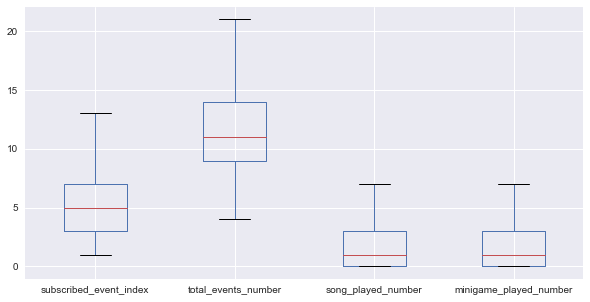

In [12]:
events_reindexed.boxplot(figsize = (10, 5));

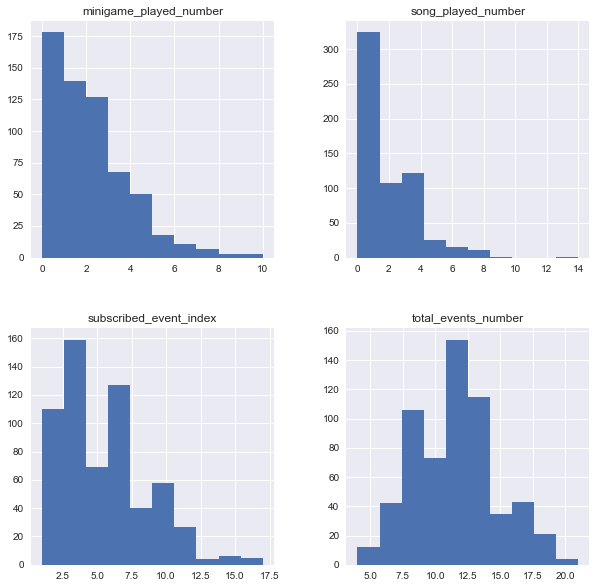

In [13]:
events_reindexed.hist(figsize = (10, 10));

Voila, on average, players who subscribed played 1.8 songs and 1.74 minigames before subscribing. However, if we take a look at the histograms we notice, that the number of songs and minigames played are actually right-skewed. So simple average is not the best metric to characterize the behaviour of players since some outliers might greatly affect and shift its value.

## Question 2

In [14]:
# take only 2 groups that we are interested in
song_conversion = events[events.group.isin(['a', 'b'])].drop(['date'], axis=1)
song_conversion = song_conversion.groupby(['group', 'uid'], as_index=False)
song_conversion = song_conversion.apply(lambda x: list(x['event'].values))
song_conversion = pd.DataFrame(song_conversion, columns=['event'])

# find out if user converted into playing a song
song_conversion['converted'] = song_conversion['event'].apply(lambda x: 'song_played' in x)

In [15]:
averages = song_conversion.groupby('group').converted.mean()
print(averages)
print('The difference is: {:.2f}%'.format((averages['b'] - averages['a'])*100))

group
a    0.981982
b    0.993994
Name: converted, dtype: float64
The difference is: 1.20%


Well, it seems like we have a 1.2% difference in our configs in favour of group B. Let's find oud if it's significant. First, we need to agree on significance level to make sure it meets our business needs and accounts for possible risks (preferably by discussing it with feature owners of "Wild Wild Chords"). But for now just assume it's a good old 5%.

In [16]:
n_rows_a = len(song_conversion.query("group == 'a'"))
n_rows_b = len(song_conversion.query("group == 'b'"))

convert_a = sum(song_conversion.query("group == 'a'")['converted'])
convert_b = sum(song_conversion.query("group == 'b'")['converted'])

p_a = averages['a']
p_b = averages['b']

First - just a simple confidence interval for difference

In [17]:
interval = 1.96 * np.sqrt((p_a*(1-p_a)/n_rows_a) + (p_b*(1-p_b)/n_rows_b))
print("Lower bond: {0:.3f}%, upper bond: {1:.3f}%".format(p_b-p_a-interval, p_b-p_a+interval))

Lower bond: -0.005%, upper bond: 0.029%


Seems like with significance level 0.05, the interval is wide enough to include zero, so we don't have enough evidence to say the groups are different.

Since we have enough observations and central limit theorem works in our favour, let's run a proportion Z-test to get p-value and see on what confidence level we can be sure that the goups are actually different.

In [18]:
z_score, p_value = sm.stats.proportions_ztest([convert_a, convert_b], 
                                              [n_rows_a, n_rows_b], 
                                              alternative='smaller')
print("Z-score={0:.3f},  p_value={1:.3f}".format(z_score, p_value))

Z-score=-1.423,  p_value=0.077


Great! Looks like even though we failed to detect any changes with significance of .05, if we lower our standards and agree on 10% probability of rejecting the null hypothesis (even though it's true), we may state that the configs are actually different and B-group is better than A. 

Finally, let's imagine that I do not remember any statistical tests at all and run a bootstrap for testing. 

Widget Javascript not detected.  It may not be installed or enabled properly.


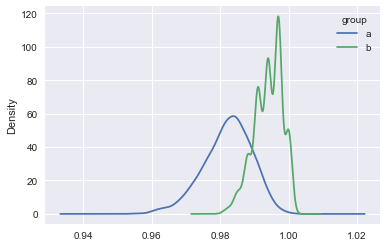

In [19]:
iterations = 1000
# Bootstrapped means for each AB-group
boot_song_conversion = []
for i in tqdm_notebook(range(iterations)):
    boot_mean = song_conversion.sample(frac=1, replace=True).groupby('group').converted.mean()
    boot_song_conversion.append(boot_mean)
boot_song_conversion = pd.DataFrame(boot_song_conversion)
    
# A kernel density estimate plot of the bootstrap distributions
boot_song_conversion.plot.kde();

Indeed it's clearly visible that bootstrapped mean distributions are quite different. Time to calculate the exact percantage differences!

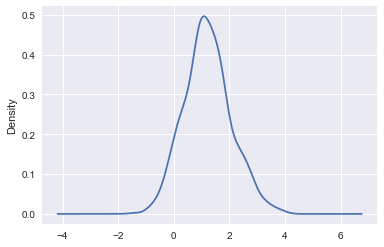

In [20]:
boot_song_conversion['diff'] = \
    (boot_song_conversion['b']-boot_song_conversion['a'])/boot_song_conversion['a'] * 100
boot_song_conversion['diff'].plot.kde();

Perfect, the difference distribution is clearly above zero for the most part of it. Now I can calculate the probability that conversion to song is greater in b group.

In [21]:
prob = (boot_song_conversion['diff']>0).mean()
print('{:.1%}'.format(prob))

92.7%


And there we go, the bootstrapped probability of group B being better than group A is 93.6%. Again, if it's safe and buisiness-justified for us to make mistakes 1 time out of 10, we can say that the groups are indeed different. 

## Question 3

Again take only a subset with target groups

In [22]:
subscription_test = events[(events.group.isin(['a', 'c']))].copy()
subscription_test['date'] = pd.to_datetime(subscription_test['date'])

And again transform "tall" into "long" dataset, adding dates and events lists for future calculations

In [23]:
subscription_test = subscription_test.groupby(['group', 'uid'], as_index=False)

subscription_events = subscription_test.apply(lambda x: list(x['event'].values))
subscription_dates = subscription_test.apply(lambda x: list(x['date'].values))

subscription_test = pd.concat([subscription_dates, subscription_events], axis=1)
subscription_test.columns = ['dates', 'events']
subscription_test.reset_index(inplace=True)

subscription_test.head()

,group,uid,dates,events
0,a,00411460f7c92d2124a67ea0f4cb5f85,"[2015-03-15T09:08:45.000000000, 2015-03-15T09:...","[app install, account created, song_played, so..."
1,a,006f52e9102a8d3be2fe5614f42ba989,"[2015-03-13T07:10:48.000000000, 2015-03-13T07:...","[app install, account created, minigame_played..."
2,a,00ec53c4682d36f5c4359f4ae7bd7ba1,"[2015-03-10T17:07:24.000000000, 2015-03-10T17:...","[app install, account created, song_played, so..."
3,a,01386bd6d8e091c2ab4c7c7de644d37b,"[2015-03-20T02:00:27.000000000, 2015-03-20T02:...","[app install, account created, song_played, mi..."
4,a,013d407166ec4fa56eb1e1f8cbe183b9,"[2015-03-17T17:00:05.000000000, 2015-03-19T17:...","[app install, account created, minigame_played..."


In [24]:
def subscriptionDays(row):
    """
        Calculate number of days before subscription,
        while user was active, and before unsubscribing
    """
    zero_day = row['dates'][0]
    last_day = row['dates'][-1]
    
    days_to_sub = np.NaN
    days_alive = np.NaN
    days_to_unsub = np.NaN
    
    def dateDiff(date_1, date_2):
        """
            Auxillary function to get the amount of days between dates
        """
        day_delta = (date_1 - date_2).astype('timedelta64[D]')
        day_delta = day_delta/np.timedelta64(1, 'D')
        return day_delta

    if 'subscribed' in row['events']:
        sub_index = row['events'].index('subscribed')
        days_to_sub = dateDiff(row['dates'][sub_index], zero_day)
        days_alive = dateDiff(last_day, zero_day)

        if 'unsubscribed' in row['events']:
            unsub_index = row['events'].index('unsubscribed')
            days_to_unsub = dateDiff(row['dates'][unsub_index], zero_day)
            
    return days_to_sub, days_alive, days_to_unsub

In [25]:
subscription_days = subscription_test.apply(subscriptionDays, axis=1)
subscription_days = pd.DataFrame(subscription_days.tolist(), 
             columns=['days_to_sub', 'days_alive', 'days_to_unsub'])
subscription_test = pd.concat([subscription_test, subscription_days], axis=1)

Now I'll add a couple more useful variables - if user converted to subscription, unsubscribed and how many days the subscription was active

In [26]:
subscription_test['converted'] = subscription_test['days_to_sub'].notnull()
subscription_test['unsubscribed'] = subscription_test['days_to_unsub'].notnull()

subscription_test['days_sub_active'] = subscription_test['days_to_unsub']-\
                                  subscription_test['days_to_sub']
subscription_test['days_sub_active'].fillna(subscription_test['days_alive']-\
                                       subscription_test['days_to_sub'], inplace=True)

subscription_test.drop(['uid', 'dates', 'events'], axis=1, inplace=True)

Finally, adding revenue

In [27]:
def calculateRevenue(row):
    """
        Calculates revenue for single user (row)
    """
    revenue = 0
    if row.converted:
        if row.group=='a':
            # each week the subscription is autorenewed
            # assuming the first payment is not refundable
            revenue = 5. + 5. * row.days_sub_active//7
        else:
            # each day the subscription is autorenewed
            # assuming the first payment is not refundable
            revenue = 0.8 + 0.8 * row.days_sub_active
        
    return revenue

In [28]:
subscription_test['revenue'] = subscription_test.apply(calculateRevenue, axis=1)

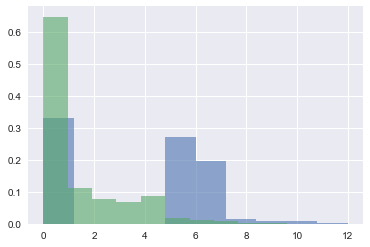

In [29]:
subscription_test.groupby('group').revenue.hist(alpha=0.6, normed=True);

In [30]:
subscription_test.groupby('group').mean().T

group,a,c
days_to_sub,2.900498,2.653266
days_alive,5.278607,5.185930
days_to_unsub,3.800000,4.105263
converted,0.603604,0.597598
unsubscribed,0.225225,0.228228
days_sub_active,1.646766,1.909548
revenue,3.528529,1.390991


So, at first glance, it seems that people in the C group have less ARPU than in the A group, conversion is slightly lower as well. Let's check if those differences are significants:

### Days of active subscription

In [31]:
days_sub_active_control = subscription_test.query("group == 'a'")['days_sub_active'].fillna(0)
days_sub_active_treat = subscription_test.query("group == 'c'")['days_sub_active'].fillna(0)

z_score, p_value = sm.stats.ztest(days_sub_active_control, 
                                  days_sub_active_treat, alternative='smaller')
print("Z-score={0:.3f},  p_value={1:.3f}".format(z_score, p_value))

Z-score=-1.064,  p_value=0.144


The results show that the average amount of days of the subscruption being active is pretty much the same between the two groups. That means that no matter the type of the sub players, on average, tend to cancel it pretty soon. 

### ARPU (average revenue per user)

In [32]:
revenue_control = subscription_test.query("group == 'a'")['revenue']
revenue_treat = subscription_test.query("group == 'c'")['revenue']

z_score, p_value = sm.stats.ztest(revenue_control, revenue_treat, alternative='larger')
print("Z-score={0:.3f},  p_value={1:.3f}".format(z_score, p_value))

Z-score=11.183,  p_value=0.000


Well, first impression was correct, ARPU of the control group with weekly subscriptions is indeed higher, so potentially those users will bring us more. 

### Conversions to subscription

In [33]:
n_rows_a = len(subscription_test.query("group == 'a'"))
n_rows_c = len(subscription_test.query("group == 'c'"))

convert_a = sum(subscription_test.query("group == 'a'")['converted'])
convert_c = sum(subscription_test.query("group == 'c'")['converted'])

z_score, p_value = sm.stats.proportions_ztest([convert_a, convert_c], 
                                              [n_rows_a, n_rows_c], 
                                              alternative='smaller')
print("Z-score={0:.3f},  p_value={1:.3f}".format(z_score, p_value))

Z-score=0.158,  p_value=0.563


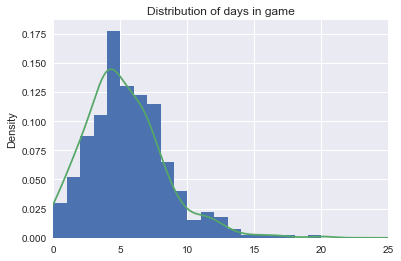

In [34]:
subscription_test.days_alive.hist(bins=20, normed=True)
subscription_test.days_alive.plot.kde()
plt.title('Distribution of days in game')
plt.xlim(0, 25);

So, we don't have enough evidence to say that conversions are any different, while ARPU is clearly bigger in the A group. That means, given the same amount of installs for both groups we will get the same amount of subscribers, but less money in C group. 

Possible explanation - retention problems. In this particular dataset we don't have users who've lived more than 20 days in the app and. On average, users have been active for 5-6 days only. That means, we rarely see any engaged players who are not willing to cancel subscription. Under these circumstances group A option of subscription obviously brings more money to the company - just because of the price that users manage to pay before leaving. 

It would be best to first address the retention problem because right now monetization depends more on the price of the offer, rather than on its type. The situation with similar conversions possibly implies that users are willing to try the paid content no matter the price range. However pretty soon they churn, leaving us wondering - why?

But that is a story for another day...

Thank you for reading!